# *svoboda lab / tactile navigation*

## Setup evnironment

In [9]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import json
import re
from scipy.stats import f_oneway
from scipy.interpolate import UnivariateSpline
from helper.plots import *
save = True

##### Setup thunder and lightning

In [4]:
from thunder import Registration
from thunder import Series
from thunder import LinearRegression
from thunder import TuningModel
from thunder import Source, SourceModel
from thunder.extraction import BasicCleaner
from thunder import Colorize
image = Colorize.image

## Setup plotting

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from colorsys import hsv_to_rgb, rgb_to_hsv
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

## Load raw data

In [6]:
path = 'https://s3.amazonaws.com/neuro.datasets/svoboda.lab/tactile.coding/'

In [7]:
iSession = 13
session = '%02g' % iSession

#### Load info

In [ ]:
r = requests.get(path + session + '/info.json').content
info = json.loads(r)
info['contributors'] = ', '.join(info['contributors'])
info['dimensions'] = str(info['dimensions'])
info = pd.DataFrame(info, index = [str(info['id'])])

#### Load params

In [548]:
covariates = pd.DataFrame.from_csv(os.path.join(path,'data',session,'params','covariates.csv'))

Summarize trial information

In [549]:
trialData = covariates[['trialType','trialNum']].groupby(['trialNum'], sort=True).first()
trialData = trialData.join(covariates[['speed','trialNum','corPos']].groupby(['trialNum'], sort=True).mean())
trialData.sort('trialType', inplace = True, ascending = False)

In [550]:
speedThresh = 3

####Load images

In [551]:
refConf = tsc.loadJSON(os.path.join(path,'data',session,'reference','conf.json'))
refConf['dims']
if len(refConf['dims']) == 3:
    nplanes = refConf['dims'][2]
else:
    nplanes = 1

In [552]:
images = tsc.loadImages(path + 'data/' + session + '/images', inputFormat='tif', nplanes=nplanes, renumber=True)

## Perform image registration

Load reference

In [553]:
ref = tsc.loadImages(path + 'data/' + session + '/reference')

Do registration

In [554]:
reg = Registration('planarcrosscorr')
reg.prepare(ref[0])
model = reg.fit(images)
trans = model.toArray()

Plot registration results

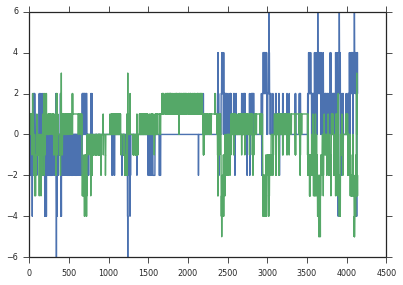

In [555]:
if nplanes > 1:
    plt.plot(trans[:,0,0]);
    plt.plot(trans[:,0,1]);
else:
    plt.plot(trans[:,0,0]);
    plt.plot(trans[:,0,1]);

Shift data and take mean

In [556]:
images = model.transform(images)
images.cache()
images.count();
mean = images.mean()

## Make local correlation

In [557]:
localCorr = images.localCorr(5)        

## Convert to series

In [558]:
series = images.toTimeSeries().squelch(50).normalize('mean')
series.cache()
series.count();

## Peform pixelwise regression

In [560]:
def buildReg(X,scale):
    maxVal = np.floor(max(X)/scale)*scale
    minVal = np.ceil(min(X)/scale)*scale
    edges = np.arange(minVal,maxVal,scale)
    edges = np.concatenate((edges, [np.Inf]))
    regMat = np.zeros([edges.shape[0]-1,X.shape[0]])
    for iEdge in range(0, edges.shape[0]-1):
        regMat[iEdge,:] = (X >= edges[iEdge]) & (X < edges[iEdge+1])
    edges = edges[:-1]
    return edges, regMat

In [561]:
regressorName = 'corPos'
pattern = re.compile('OL_.*R|OL_out')
indexOL = covariates.trialType.str.match(pattern, as_indexer=True)
mask = (covariates.itiPeriod == 0) & indexOL & (covariates.speed > speedThresh)
edges, regMat = buildReg(covariates[regressorName][mask==True].values,3)
results = LinearRegression('ordinary', intercept=False).fit(regMat.T, series.applyValues(lambda v: v[mask.values==True]))
betas = results.coeffs
rsq = results.stats.pack()
t = TuningModel.load(edges,'gaussian')
tune = t.fit(betas).select('center').pack()

## Extract source timeseries

Load sources

In [562]:
sources = tsc.loadSources(path + 'data/' + session + '/sources/sources.json')

Generate source timeseries

In [563]:
tsRoiRaw = sources.transform(images, collect = False)

Calculate neuropil signal by first generating source outline

In [564]:
outline = []
for iplane in range(1,4):
    index = np.where([x[2] == iplane for x in sources.centers])[0]
    sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
    sourcesPlane = sourcesPlane.outline(2,5).crop([0,0],[512,512])
    new = [[l+[iplane] for l in x] for x in sourcesPlane.coordinates]
    outline = outline + new
sourcesOutline = SourceModel(outline)

In [565]:
tsRoiOutlineRaw = sourcesOutline.transform(images, collect = False)

Convert to dff space and perform neuropil subtraction

Normalize and convert to table

In [566]:
tsRoi = tsRoiRaw.toTimeSeries()
tsRoi = tsRoi.normalize('window-fast',1260)
tsRoi.cache();
timeseriesRaw = pd.DataFrame(np.array(tsRoi.values().collect()))
timeseriesRaw.index.name = 'sourceId'

In [567]:
tsRoiNeuropil = tsRoiOutlineRaw.toTimeSeries()
tsRoiNeuropil = tsRoiNeuropil.normalize('window-fast',1260)
tsRoiNeuropil.cache();
timeseriesNeuropil = pd.DataFrame(np.array(tsRoiNeuropil.values().collect()))
timeseriesNeuropil.index.name = 'sourceId'

In [568]:
timeseries = timeseriesRaw - timeseriesNeuropil

#Plot maps

Select plane

In [ ]:
iplane = 2

#### Plot pixelwise regression map

In [10]:
pal = colormap(0)
colorbar(pal)

In [ ]:
c = Colorize(cmap=pal, scale=1, vmin=0, vmax=25)
img = c.transform(tune,background=mean.clip(min=0, max=300),mask=np.sqrt(rsq).clip(min=0.05,max=0.6),mixing=.3)
image(img[:,:,iplane])

#### Plot sources

In [ ]:
index = np.where([x[2] == iplane for x in sources.centers])[0]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', base=mean[:,:,iplane].clip(0,500))
image(img)
for s in range(sourcesPlane.count):
    plt.annotate(s=str(index[s]), xy=sourcesPlane[s].center[[1,0]], color='w');

In [ ]:
index = [160, 150, 159]
sourcesPlane = SourceModel([np.asarray(sources[s].coordinates)[:,0:2].tolist() for s in index])
img = sourcesPlane.masks(mean.shape[0:2], color='red', outline=False, base=mean[:,:,iplane].clip(0,500))
image(img)